# Predicting Music Listening Time with Music/Mental Health Data

In [615]:
#Imports here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

## 1. Introduction

The primary research goal for this analysis will be to build a predictive model that will predict listening time for music listeners in new datasets. Ideally, this model will also be able to provide interpretable insights regarding the relationships between the variables in the music dataset.

Building this predictive model may be beneficial for therapists or others working in the mental health field to inform their treatment methods by assessing how patients' mental health relate to their music listening habits.

## 2. Dataset Discussion

The dataset I will be using is the Music & Mental Health Survey Results dataset from Kaggle. It was downloaded from https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results?resource=download on March 17, 2025. This dataset contains 736 rows and 33 columns. Each row contains one individual's survey response with variables for music listening habits (hours, streaming services, genres listened to, etc) and self-rated experiences with anxiety, depression, insomnia, and OCD on a scale of 1-10.

In [580]:
df = pd.read_csv('mxmh_survey_results.csv')
df.head(5)

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


In [581]:
df.shape

(736, 33)

In [582]:
df.columns

Index(['Timestamp', 'Age', 'Primary streaming service', 'Hours per day',
       'While working', 'Instrumentalist', 'Composer', 'Fav genre',
       'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]',
       'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Music effects',
       'Permissions'],
      dtype='object')

## 3. Dataset Cleaning

Because my model will predict listening time (hours per day) based on individuals' music tastes and mental health ratings, I created a dataframe with only the variables needed for the analysis and dropping the other columns (frequencies, streaming service, instrumentalist/composer, while working, music effects, permissions, timestamp, age).

In [583]:
df = df[['Hours per day', 'Fav genre', 'Exploratory', 'Foreign languages', 'BPM', 
       'Anxiety', 'Depression', 'Insomnia', 'OCD']]
df = df.rename(columns={'Hours per day': 'Hours_per_day', 'Fav genre': 'Fav_genre', 'Foreign languages': 'Foreign_languages'})
df

,Hours_per_day,Fav_genre,Exploratory,Foreign_languages,BPM,Anxiety,Depression,Insomnia,OCD
0,3.0,Latin,Yes,Yes,156.0,3.0,0.0,1.0,0.0
1,1.5,Rock,Yes,No,119.0,7.0,2.0,2.0,1.0
2,4.0,Video game music,No,Yes,132.0,7.0,7.0,10.0,2.0
3,2.5,Jazz,Yes,Yes,84.0,9.0,7.0,3.0,3.0
4,4.0,R&B,Yes,No,107.0,7.0,2.0,5.0,9.0
...,...,...,...,...,...,...,...,...,...
731,2.0,Rock,Yes,Yes,120.0,7.0,6.0,0.0,9.0
732,1.0,Pop,Yes,Yes,160.0,3.0,2.0,2.0,5.0
733,6.0,Rap,Yes,No,120.0,2.0,2.0,2.0,2.0
734,5.0,Classical,No,No,170.0,2.0,3.0,2.0,1.0


df.dtypes shows that there are no missing values for the numerical variables in this dataset:

In [584]:
df.dtypes

Hours_per_day        float64
Fav_genre             object
Exploratory           object
Foreign_languages     object
BPM                  float64
Anxiety              float64
Depression           float64
Insomnia             float64
OCD                  float64
dtype: object

By displaying the values in each column, we can see that there are no rows with explicit missing values. The isna().value_counts() function shows that there are rows with implicit missing values that need to be dropped.

In [585]:
for col in df.columns:
    print(df[col].unique())

[ 3.    1.5   4.    2.5   5.    1.    6.    8.    2.   12.   24.    0.5
  0.25  0.    7.   10.    9.    0.7   4.5  20.   16.   15.   14.   13.
  0.1  11.   18.  ]
['Latin' 'Rock' 'Video game music' 'Jazz' 'R&B' 'K pop' 'Country' 'EDM'
 'Hip hop' 'Pop' 'Rap' 'Classical' 'Metal' 'Folk' 'Lofi' 'Gospel']
['Yes' 'No']
['Yes' 'No' nan]
[1.56000000e+02 1.19000000e+02 1.32000000e+02 8.40000000e+01
 1.07000000e+02 8.60000000e+01 6.60000000e+01 9.50000000e+01
 9.40000000e+01 1.55000000e+02            nan 1.25000000e+02
 8.80000000e+01 1.48000000e+02 1.03000000e+02 1.20000000e+02
 9.90000000e+01 1.18000000e+02 7.90000000e+01 1.69000000e+02
 1.36000000e+02 1.01000000e+02 1.26000000e+02 1.83000000e+02
 1.42000000e+02 7.50000000e+01 8.90000000e+01 1.40000000e+02
 1.61000000e+02 8.00000000e+01 1.30000000e+02 1.47000000e+02
 7.70000000e+01 1.15000000e+02 1.57000000e+02 9.00000000e+01
 1.28000000e+02 9.60000000e+01 9.10000000e+01 5.50000000e+01
 8.50000000e+01 1.60000000e+02 1.08000000e+02 1.70000000e+

In [586]:
df.isna().value_counts()

Hours_per_day  Fav_genre  Exploratory  Foreign_languages  BPM    Anxiety  Depression  Insomnia  OCD  
False          False      False        False              False  False    False       False     False    626
                                                          True   False    False       False     False    106
                                       True               False  False    False       False     False      3
                                                          True   False    False       False     False      1
Name: count, dtype: int64

In [587]:
df.shape[0]

736

In [588]:
df = df.dropna()

In [589]:
736 - df.shape[0]

110

A total of 110 rows with missing values were dropped.

Next, I checked the numerical variables for outlier points. The BPM boxplot shows that there is one high outlier and the Hours per day boxplot shows that there are a few high outliers. I chose to remove the high outlier for the BPM variable because it appears to be significantly larger than all other observations in the dataset. I decided to keep the outliers in the hours per day variable because they may help make the final model more robust toward other outliers in new datasets.

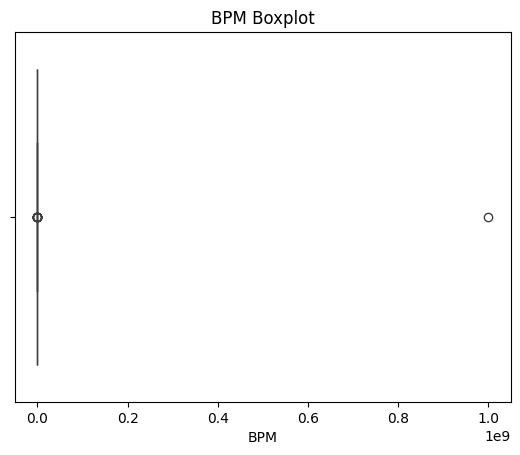

In [590]:
sns.boxplot(x='BPM', data=df)
plt.title("BPM Boxplot")
plt.show()

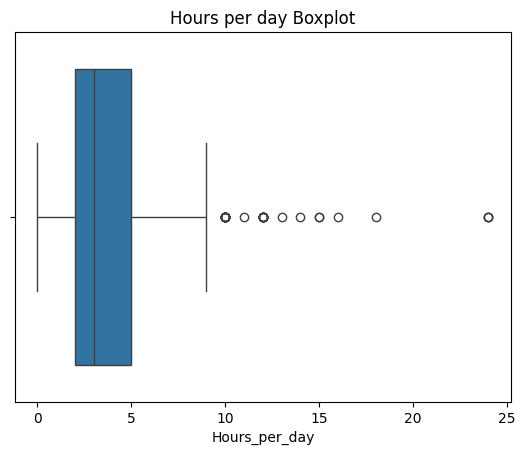

In [591]:
sns.boxplot(x='Hours_per_day', data=df)
plt.title("Hours per day Boxplot")
plt.show()

In [592]:
df = df[df['BPM'] < 1e8]

In [593]:
df.shape[0]

625

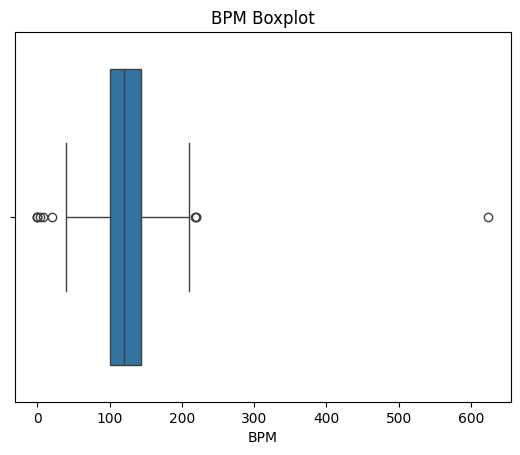

In [594]:
sns.boxplot(x='BPM', data=df)
plt.title("BPM Boxplot")
plt.show()

After removing the high outlier, the boxplot shows that there are still low and high outliers for the BPM variable that I chose to remove:

In [595]:
q1 = df['BPM'].quantile(0.25)
q3 = df['BPM'].quantile(0.75)
iqr = q3 - q1

In [596]:
df = df[(df['BPM'] >= q1 - 1.5 * iqr) & (df['BPM'] <= q3 + 1.5 * iqr)]
df.shape[0]

615

10 outliers were dropped.

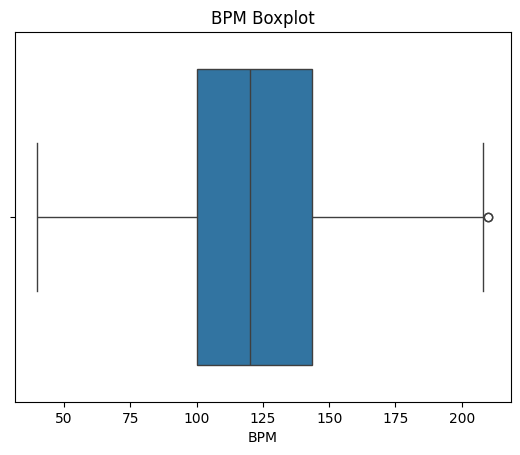

In [597]:
sns.boxplot(x='BPM', data=df)
plt.title("BPM Boxplot")
plt.show()

## 4. Preliminary Analysis

For the initial analysis, I first created scatterplots for each pair of numerical variables below:

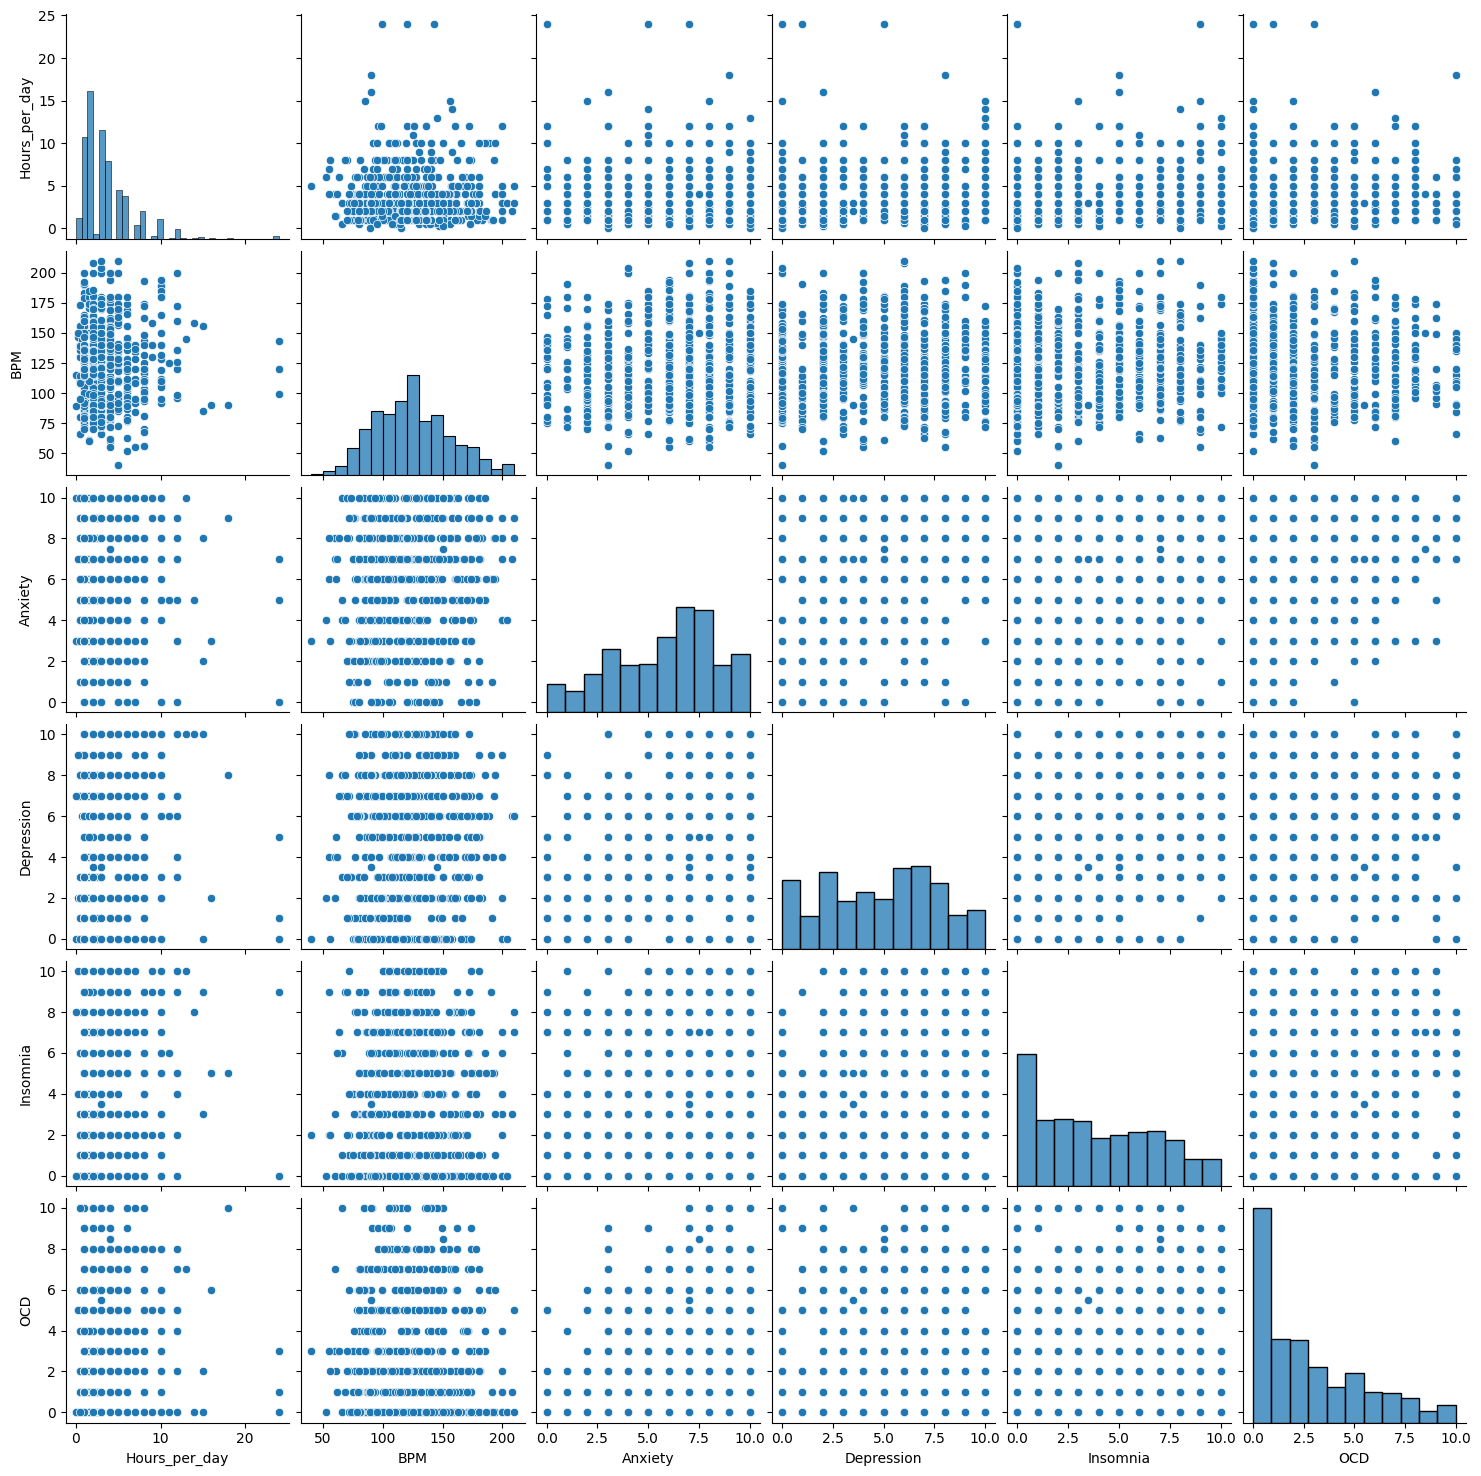

In [598]:
sns.pairplot(data=df)
plt.show()

Next, I fitted a linear regression model to predict hours_per_day with all explanatory variables.

In [599]:
full_mod = smf.ols(formula='Hours_per_day~Fav_genre+Exploratory+Foreign_languages+BPM+Anxiety+Depression+Insomnia+OCD', data = df).fit()

Based on the fitted values vs residuals plot for this full model, the dataset does not satisfy the linearity assumption as there is an uneven distribution of positive and negative residuals across the plot.

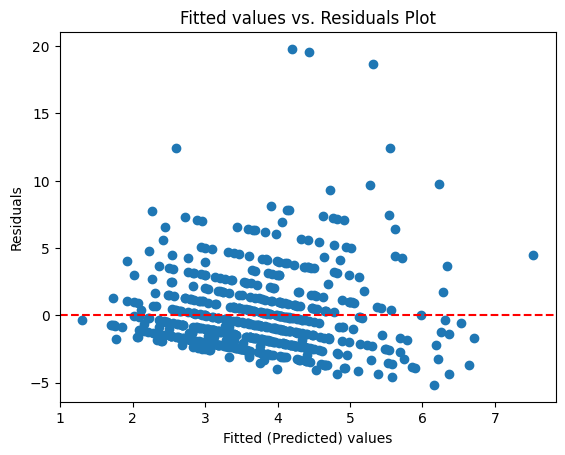

In [600]:
plt.scatter(full_mod.fittedvalues, full_mod.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted (Predicted) values')
plt.ylabel('Residuals')
plt.title('Fitted values vs. Residuals Plot')
plt.show()

The BPM variable has a much higher standard deviation compared to the rest of the numerical variables (31.44 compared to the rest of the variables which are all around 3). Transforming the BPM variable might help with the linearity of the data.

In [601]:
df.describe()

,Hours_per_day,BPM,Anxiety,Depression,Insomnia,OCD
count,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000
mean,3.739350,123.299187,5.877236,4.871545,3.807317,2.637398
std,3.106414,31.449949,2.756686,3.001181,3.108100,2.844115
min,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,100.000000,4.000000,2.000000,1.000000,0.000000
50%,3.000000,120.000000,6.000000,5.000000,3.000000,2.000000
75%,5.000000,143.500000,8.000000,7.000000,6.000000,5.000000
max,24.000000,210.000000,10.000000,10.000000,10.000000,10.000000


I modified the BPM variable using a log transformation and then refitted the full model:

In [602]:
df['BPM_log'] = np.log(df['BPM'])
df.head()

,Hours_per_day,Fav_genre,Exploratory,Foreign_languages,BPM,Anxiety,Depression,Insomnia,OCD,BPM_log
0,3.0,Latin,Yes,Yes,156.0,3.0,0.0,1.0,0.0,5.049856
1,1.5,Rock,Yes,No,119.0,7.0,2.0,2.0,1.0,4.779123
2,4.0,Video game music,No,Yes,132.0,7.0,7.0,10.0,2.0,4.882802
3,2.5,Jazz,Yes,Yes,84.0,9.0,7.0,3.0,3.0,4.430817
4,4.0,R&B,Yes,No,107.0,7.0,2.0,5.0,9.0,4.672829


In [603]:
df.describe()

,Hours_per_day,BPM,Anxiety,Depression,Insomnia,OCD,BPM_log
count,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000
mean,3.739350,123.299187,5.877236,4.871545,3.807317,2.637398,4.780919
std,3.106414,31.449949,2.756686,3.001181,3.108100,2.844115,0.264224
min,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,3.688879
25%,2.000000,100.000000,4.000000,2.000000,1.000000,0.000000,4.605170
50%,3.000000,120.000000,6.000000,5.000000,3.000000,2.000000,4.787492
75%,5.000000,143.500000,8.000000,7.000000,6.000000,5.000000,4.966329
max,24.000000,210.000000,10.000000,10.000000,10.000000,10.000000,5.347108


In [604]:
full_mod2 = smf.ols(formula='Hours_per_day~Fav_genre+Exploratory+Foreign_languages+BPM_log+Anxiety+Depression+Insomnia+OCD', data = df).fit()

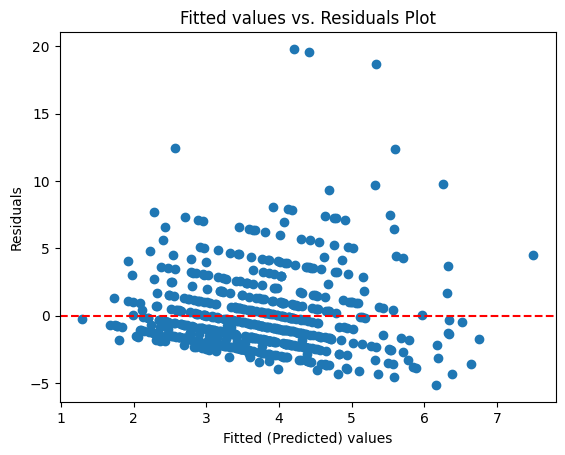

In [605]:
plt.scatter(full_mod2.fittedvalues, full_mod2.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted (Predicted) values')
plt.ylabel('Residuals')
plt.title('Fitted values vs. Residuals Plot')
plt.show()

In [606]:
df = df.drop(columns=['BPM_log'])

Overall, the fitted values vs residuals plot seems to be about the same - transforming the BPM variable did not help much with the linearity assumption.

Next, I created scatterplots to analyze the interaction terms. Favorite genre seems to have a strong interaction with each numerical variable (BPM, anxiety, depression, insomnia, OCD) in impacting the hours spent listening to music because the best fit line slopes (numerical variable vs hours_per_day) varies by genre. The exploratory variable also has interactions with each numerical variable. Foreign_languages has slight interactions with BPM, insomnia, and OCD in impacting the hours spent listening to music.

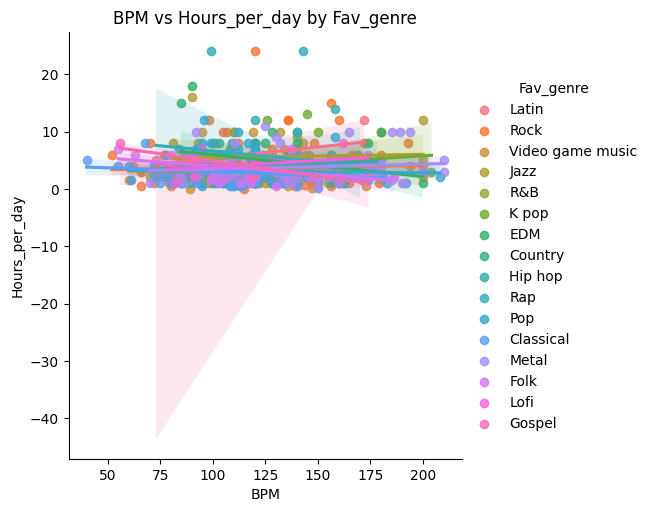

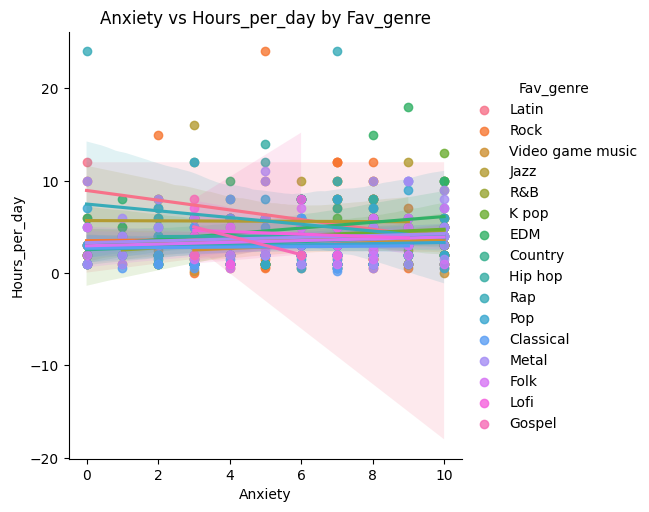

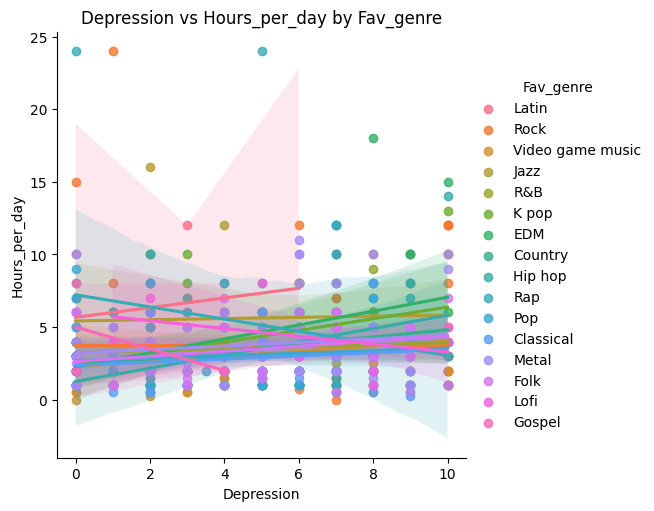

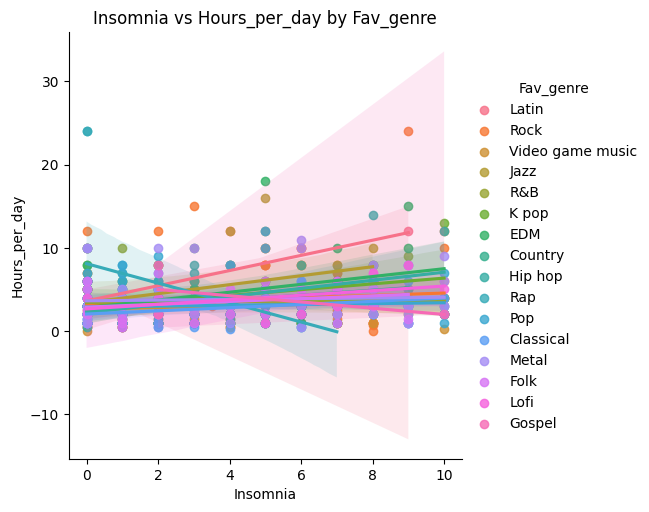

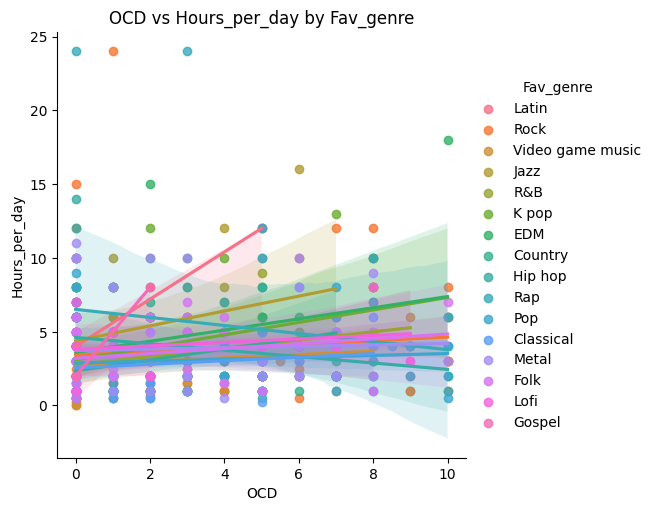

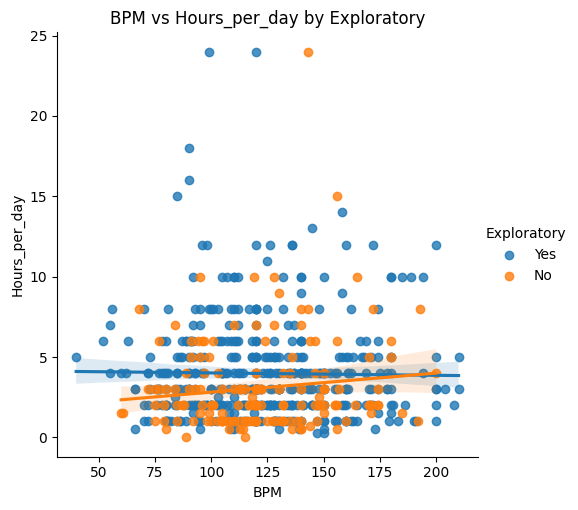

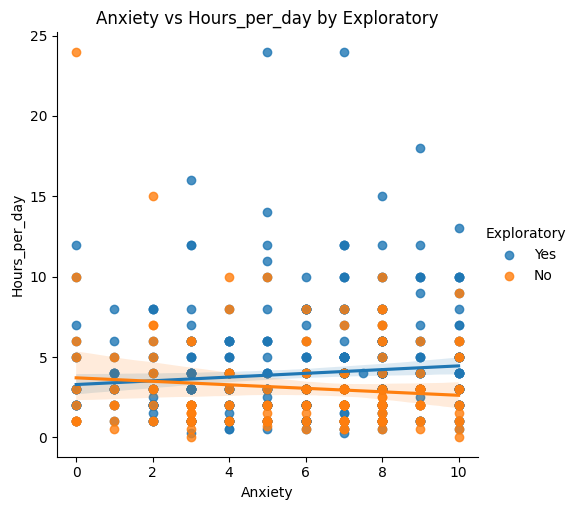

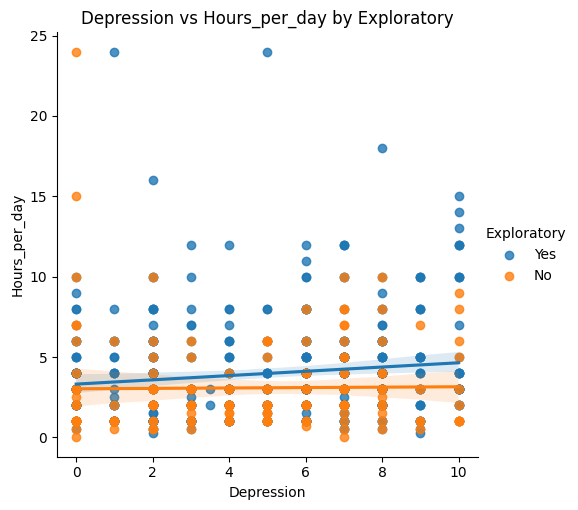

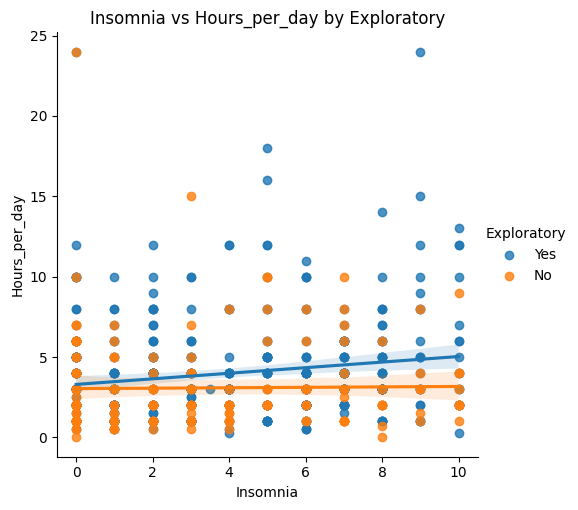

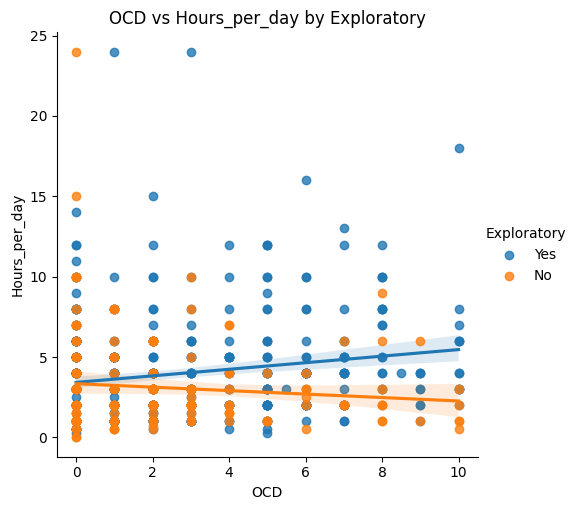

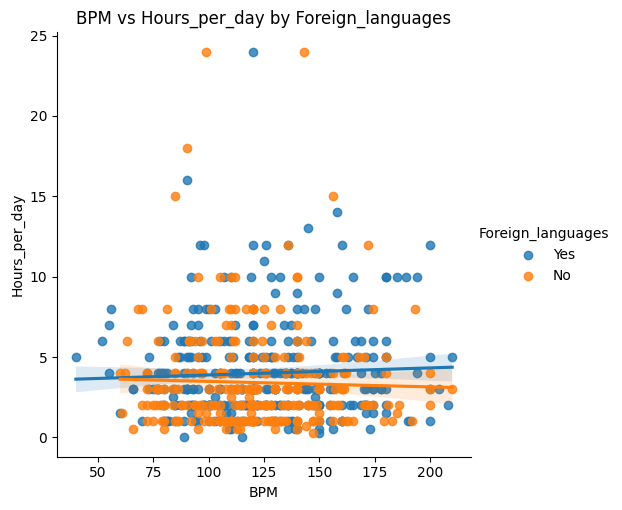

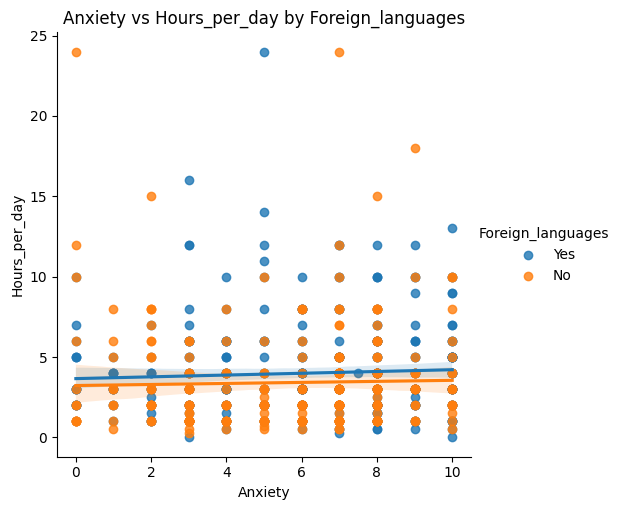

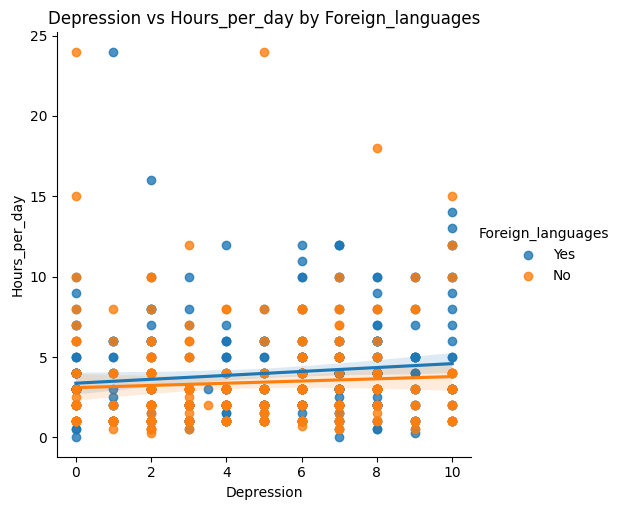

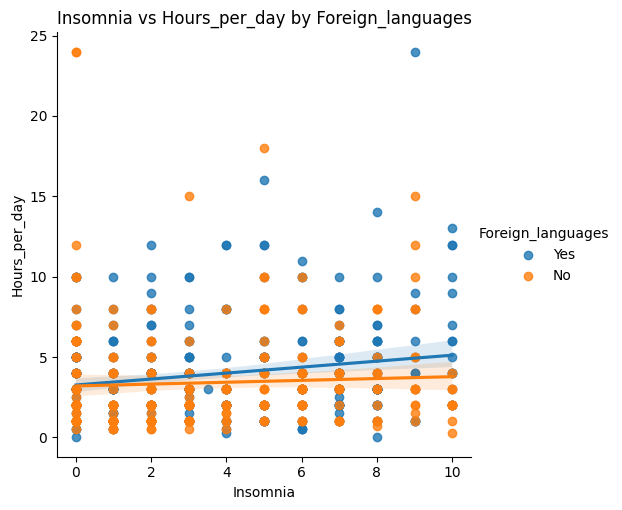

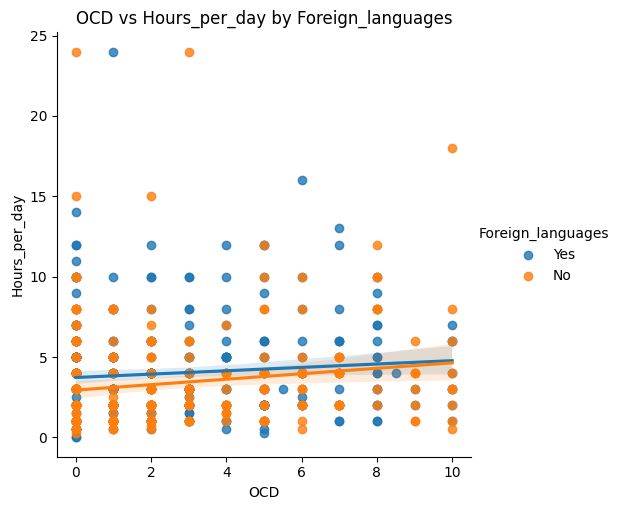

In [607]:
for cat in ['Fav_genre','Exploratory','Foreign_languages']:
    for num in ['BPM','Anxiety','Depression','Insomnia','OCD']:
        sns.lmplot(x=num, y='Hours_per_day', hue=cat, data=df)
        plt.title(num+' vs Hours_per_day by '+cat)
        plt.show()

## 5. Predictive Models

First, I split the original cleaned dataset into a training and test dataset. Then I used z-score scaling to scale the training and test numerical variables using the training means/standard deviations.

In [608]:
# Split into train/test datasets
df_train, df_test = train_test_split(df, random_state=111, test_size=0.2)
df_train.shape[0]

492

In [609]:
# Create features matrix/target arrays
X_train = df_train.drop(['Hours_per_day'], axis=1)
y_train = df_train['Hours_per_day']
X_test = df_test.drop(['Hours_per_day'], axis=1)
y_test = df_test['Hours_per_day']

In [ ]:
# Scale training variables
scaler_training = StandardScaler()
scaled_expl_vars = scaler_training.fit_transform(df_train[['BPM', 'Anxiety', 'Depression', 'Insomnia', 'OCD']])
df_train[['BPM', 'Anxiety', 'Depression', 'Insomnia', 'OCD']] = scaled_expl_vars
df_train.head()

,Hours_per_day,Fav_genre,Exploratory,Foreign_languages,BPM,Anxiety,Depression,Insomnia,OCD
119,0.5,Folk,Yes,No,0.223066,-0.659936,0.715094,-0.902499,-0.909153
140,4.0,Lofi,Yes,Yes,-1.367493,-1.013051,1.046693,-1.224610,-0.909153
327,2.0,Pop,No,No,-0.088808,0.399407,0.715094,-0.258278,-0.194611
168,3.0,K pop,Yes,Yes,-0.275933,0.752521,1.378291,0.708054,-0.909153
255,0.5,Video game music,No,Yes,0.410191,0.046292,-0.611301,-0.902499,-0.551882


In [611]:
# Scale test variables
scaled_expl_vars = scaler_training.fit_transform(df_test[['BPM', 'Anxiety', 'Depression', 'Insomnia', 'OCD']])
df_test[['BPM', 'Anxiety', 'Depression', 'Insomnia', 'OCD']] = scaled_expl_vars
df_test.head()

,Hours_per_day,Fav_genre,Exploratory,Foreign_languages,BPM,Anxiety,Depression,Insomnia,OCD
278,4.0,Video game music,Yes,Yes,-1.539371,0.863594,0.347171,0.376481,1.34035
405,2.0,Rock,Yes,Yes,0.554741,-2.442928,0.005555,1.019637,-1.01004
595,8.0,Lofi,Yes,Yes,1.287680,0.036963,0.005555,1.662792,1.67612
523,6.0,R&B,No,Yes,0.729250,-1.202983,0.005555,-1.231407,-0.33850
326,3.0,Pop,Yes,Yes,-0.422511,0.036963,-1.019295,-0.266674,-0.67427


Next, I fitted a full non-regularized linear regression model and computed the test R^2. I originally attempted to transform the BPM variable (in the preliminary analysis), however, the transformation did not seem to help with the model's linearity so this full model includes the non-transformed BPM variable.

In [612]:
full_mod = smf.ols(formula='Hours_per_day~Fav_genre+Exploratory+Foreign_languages+BPM+Anxiety+Depression+Insomnia+OCD', data=df_train).fit()
full_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Hours_per_day   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.410
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           0.000391
Time:                        14:27:23   Log-Likelihood:                -1241.7
No. Observations:                 492   AIC:                             2529.
Df Residuals:                     469   BIC:                             2626.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.5187      0.557      4.526      0.000       1.425       3.612
Fav_genre[T.Country]              0.8577      0.979      0.876      0.381      -1.066       2.782
Fav_genre[T.EDM]                  1.7502      0.767      2.282      0.023       0.243       3.257
Fav_genre[T.Folk]                 0.8115      0.922      0.880      0.379      -1.000       2.623
Fav_genre[T.Gospel]               2.0499      2.256      0.909      0.364      -2.383       6.483
Fav_genre[T.Hip hop]              0.6704      0.834      0.804      0.422      -0.969       2.310
Fav_genre[T.Jazz]                 3.5894      1.013      3.544      0.000       1.599       5.579
Fav_genre[T.K pop]                0.4931      0.876      0.563      0.574      -1.228       2.214
Fav_genre[T.Latin]                3.6385      1.868      1.948      0.052      -0.032       7.309
Fav_genre[T.Lofi]                 0.1695      1.224      0.138      0.890      -2.236       2.575
Fav_genre[T.Metal]                0.7117      0.668      1.066      0.287      -0.601       2.024
Fav_genre[T.Pop]                  0.0828      0.632      0.131      0.896      -1.159       1.324
Fav_genre[T.R&B]                  0.3438      0.796      0.432      0.666      -1.221       1.908
Fav_genre[T.Rap]                  3.1318      0.965      3.245      0.001       1.236       5.028
Fav_genre[T.Rock]                 0.7189      0.596      1.205      0.229      -0.453       1.891
Fav_genre[T.Video game music]     0.4055      0.790      0.513      0.608      -1.147       1.958
Exploratory[T.Yes]                0.4326      0.333      1.298      0.195      -0.222       1.088
Foreign_languages[T.Yes]          0.3483      0.304      1.145      0.253      -0.249       0.946
BPM                              -0.1064      0.146     -0.728      0.467      -0.394       0.181
Anxiety                          -0.2138      0.180     -1.187      0.236      -0.568       0.140
Depression                        0.1382      0.181      0.764      0.445      -0.217       0.494
Insomnia                          0.3156      0.158      2.003      0.046       0.006       0.625
OCD                               0.3289      0.152      2.157      0.032       0.029       0.628
==============================================================================
Omnibus:                      275.406   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2333.597
Skew:                           2.320   Prob(JB):                         0.00
Kurtosis:                      12.607   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix

In [616]:
y_test = df_test['Hours_per_day']
y_pred_test = full_mod.predict(df_test)
r2_score(y_test, y_pred_test)

-0.029431266356987118

Then, I fitted a model with the interactions between the fav_genre variable and the numerical variables BPM, Anxiety, Depression, Insomnia, and OCD, and computed the test R^2.

In [613]:
interaction_mod = smf.ols(formula='Hours_per_day~Fav_genre+Exploratory+Foreign_languages+BPM+Anxiety+Depression+Insomnia+OCD+BPM*Fav_genre+Anxiety*Fav_genre+Depression*Fav_genre+Insomnia*Fav_genre+OCD*Fav_genre', data=df_train).fit()
interaction_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Hours_per_day   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     1.536
Date:                Wed, 19 Mar 2025   Prob (F-statistic):            0.00298
Time:                        14:29:16   Log-Likelihood:                -1195.2
No. Observations:                 492   AIC:                             2572.
Df Residuals:                     401   BIC:                             2954.
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    2.3765      0.590      4.027      0.000       1.216       3.537
Fav_genre[T.Country]                         2.2556      1.474      1.530      0.127      -0.642       5.153
Fav_genre[T.EDM]                             2.6065      0.870      2.995      0.003       0.895       4.318
Fav_genre[T.Folk]                            0.7530      1.054      0.714      0.476      -1.320       2.826
Fav_genre[T.Gospel]                          0.5366      0.803      0.668      0.504      -1.042       2.116
Fav_genre[T.Hip hop]                         0.5644      0.896      0.630      0.529      -1.197       2.326
Fav_genre[T.Jazz]                            3.8806      1.264      3.071      0.002       1.396       6.365
Fav_genre[T.K pop]                           0.9413      0.909      1.035      0.301      -0.846       2.729
Fav_genre[T.Latin]                           4.7131      2.096      2.248      0.025       0.592       8.835
Fav_genre[T.Lofi]                            9.0545      8.118      1.115      0.265      -6.905      25.013
Fav_genre[T.Metal]                           0.7851      0.715      1.098      0.273      -0.621       2.191
Fav_genre[T.Pop]                             0.1959      0.664      0.295      0.768      -1.110       1.502
Fav_genre[T.R&B]                             0.4654      0.837      0.556      0.578      -1.179       2.110
Fav_genre[T.Rap]                             0.4560      1.358      0.336      0.737      -2.214       3.126
Fav_genre[T.Rock]                            0.9386      0.620      1.515      0.131      -0.279       2.157
Fav_genre[T.Video game music]                0.6778      0.904      0.749      0.454      -1.100       2.456
Exploratory[T.Yes]                           0.3797      0.352      1.080      0.281      -0.311       1.071
Foreign_languages[T.Yes]                     0.4143      0.321      1.292      0.197      -0.216       1.045
BPM                                         -0.3826      0.510     -0.750      0.454      -1.386       0.621
BPM:Fav_genre[T.Country]                     1.9439      1.914      1.016      0.310      -1.819       5.707
BPM:Fav_genre[T.EDM]                        -1.3253      0.893     -1.485      0.138      -3.080       0.429
BPM:Fav_genre[T.Folk]                       -0.4801      1.066     -0.450      0.653      -2.576       1.616
BPM:Fav_genre[T.Gospel]                     -0.9254      0.774     -1.196      0.233      -2.447       0.596
BPM:Fav_genre[T.Hip hop]                     0.7188      0.916      0.785      0.433      -1.082       2.520
BPM:Fav_genre[T.Jazz]                        1.6504      1.145      1.441      0.150      -0.601       3.902
BPM:Fav_genre[T.K pop]         

In [617]:
y_test = df_test['Hours_per_day']
y_pred_test = interaction_mod.predict(df_test)
r2_score(y_test, y_pred_test)

-0.7552314135429845

The last model I fitted was a backward elimination algorithm model. Starting with the full model and all explanatory variables:

In [618]:
current_mod = smf.ols(formula='Hours_per_day~Fav_genre+Exploratory+Foreign_languages+BPM+Anxiety+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = current_mod.predict(df_test)
r2_score(y_test, y_pred_test)

-0.029431266356987118

In [620]:
# Remove fav_genre
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+BPM+Anxiety+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.07635482432499086

In [621]:
# Remove exploratory
test_mod = smf.ols(formula='Hours_per_day~Fav_genre+Foreign_languages+BPM+Anxiety+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

-0.041874949960062136

In [622]:
# Remove foreign_languages
test_mod = smf.ols(formula='Hours_per_day~Fav_genre+Exploratory+BPM+Anxiety+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

-0.03967789866618765

In [623]:
# Remove bpm
test_mod = smf.ols(formula='Hours_per_day~Fav_genre+Exploratory+Foreign_languages+Anxiety+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

-0.019167365017651816

In [624]:
# Remove anxiety
test_mod = smf.ols(formula='Hours_per_day~Fav_genre+Exploratory+Foreign_languages+BPM+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

-0.017020402573777904

In [625]:
# Remove depression
test_mod = smf.ols(formula='Hours_per_day~Fav_genre+Exploratory+Foreign_languages+BPM+Anxiety+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

-0.03822427752547197

In [626]:
# Remove insomnia
test_mod = smf.ols(formula='Hours_per_day~Fav_genre+Exploratory+Foreign_languages+BPM+Anxiety+Depression+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

-0.04354148140102354

In [627]:
# Remove ocd
test_mod = smf.ols(formula='Hours_per_day~Fav_genre+Exploratory+Foreign_languages+BPM+Anxiety+Depression+Insomnia', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

-0.03726729487669411

Removing the fav_genre variable results in the highest test R^2 (0.076). The current model gets updated to:

In [ ]:
current_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+BPM+Anxiety+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = current_mod.predict(df_test)
r2_score(y_test, y_pred_test)

In [628]:
# Remove exploratory
test_mod = smf.ols(formula='Hours_per_day~Foreign_languages+BPM+Anxiety+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.05501670228720601

In [629]:
# Remove foreign_languages
test_mod = smf.ols(formula='Hours_per_day~Exploratory+BPM+Anxiety+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.06342587128375932

In [630]:
# Remove bpm
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+Anxiety+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.07750266481342138

In [631]:
# Remove anxiety
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+BPM+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.09283026314847675

In [632]:
# Remove depression
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+BPM+Anxiety+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.06647713820897372

In [633]:
# Remove insomnia
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+BPM+Anxiety+Depression+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.06811671961787102

In [634]:
# Remove ocd
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+BPM+Anxiety+Depression+Insomnia', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.0700772858928167

Removing anxiety results in the highest test R^2. The current model gets updated to: 

In [635]:
current_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+BPM+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = current_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.09283026314847675

In [636]:
# Remove exploratory
test_mod = smf.ols(formula='Hours_per_day~Foreign_languages+BPM+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.0706361315905153

In [637]:
# Remove foreign_languages
test_mod = smf.ols(formula='Hours_per_day~Exploratory+BPM+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.07975173775075473

In [638]:
# Remove bpm
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.0958134469184394

In [639]:
# Remove depression
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+BPM+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.08998634347316281

In [640]:
# Remove insomnia
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+BPM+Depression+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.08816622726814227

In [641]:
# Remove ocd
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+BPM+Depression+Insomnia', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.08176924941889951

Removing BPM results in the highest test R^2 (0.0958). The current model gets updated to:

In [642]:
current_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = current_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.0958134469184394

In [643]:
# Remove exploratory
test_mod = smf.ols(formula='Hours_per_day~Foreign_languages+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.07284619398519154

In [644]:
# Remove foreign_languages
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Depression+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.08325479434427185

In [645]:
# Remove depression
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+Insomnia+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.09307849877457319

In [646]:
# Remove insomnia
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+Depression+OCD', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.08974117243901492

In [647]:
# Remove ocd
test_mod = smf.ols(formula='Hours_per_day~Exploratory+Foreign_languages+Depression+Insomnia', data=df_train).fit()
y_test = df_test['Hours_per_day']
y_pred_test = test_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.08505274679941577

None of the test R^2 values are higher compared to the current model, so the final model using the backward elimination algorithm predicts Hours_per_day using Exploratory, Foreign_languages, Depression, Insomnia, and OCD with a test R^2 of 0.0958.

In [649]:
y_test = df_test['Hours_per_day']
y_pred_test = current_mod.predict(df_test)
r2_score(y_test, y_pred_test)

0.0958134469184394

In [653]:
current_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Hours_per_day   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3.540
Date:                Wed, 19 Mar 2025   Prob (F-statistic):            0.00374
Time:                        15:11:08   Log-Likelihood:                -1259.3
No. Observations:                 492   AIC:                             2531.
Df Residuals:                     486   BIC:                             2556.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.1226      0.298     10.478      0.000       2.537       3.708
Exploratory[T.Yes]           0.6416      0.330      1.941      0.053      -0.008       1.291
Foreign_languages[T.Yes]     0.3401      0.297      1.146      0.252      -0.243       0.923
Depression                   0.0211      0.156      0.135      0.892      -0.286       0.328
Insomnia                     0.2889      0.157      1.844      0.066      -0.019       0.597
OCD                          0.2881      0.147      1.965      0.050   -3.24e-05       0.576
==============================================================================
Omnibus:                      315.259   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3398.886
Skew:                           2.674   Prob(JB):                         0.00
Kurtosis:                      14.713   Cond. No.                         4.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 6. Best Model Discussion

The model with the highest test R^2 is the backward elimination model with the equation: 

\begin{equation}
\begin{aligned}
\hat{Hours per day} &= 3.1226 \\
&+ 0.6416 \times \text{Exploratory[T. Yes]} \\
&+ 0.3401 \times \text{Foreign languages[T. Yes]} \\
&+ 0.0211 \times \text{Depression} \\
&+ 0.2889 \times \text{Insomnia} \\
&+ 0.2881 \times \text{OCD} 
\end{aligned}
\end{equation}

Overall, this final model is not a good fit for the test dataset. The test R^2 value is extremely low at 0.09 which indicates that the explanatory variables only account for about 9% of the total variance of the hours spent listening to music per day.

Based on the backward elimination algorithm, this final model suggests that the fav_genre and BPM variables were overfitting the model. Removing them resulted in a higher test R^2 compared to the original full model.
 
By calculating the correlation metrics between the numerical variables, we see that there are no issues with multicollinearity in the model as the correlation between all pairs of variables is below 0.7:

In [652]:
df[['Depression', 'Insomnia', 'OCD']].corr()

,Depression,Insomnia,OCD
Depression,1.000000,0.372776,0.172890
Insomnia,0.372776,1.000000,0.211009
OCD,0.172890,0.211009,1.000000


Because there are no issues with multicollinearity, the slopes of the final model can be interpreted as indications of the importance of each explanatory variable in predicting the hours_per_day response variable. The exploratory variable is the most important in predicting hours_per_day, foreign languages is the second most important, insomnia is the third most important, OCD is the fourth most important, and depression is the fifth most important.

## 7. Conclusion

Based on the final model:
- The expected # of hours spent listening to music per day for a listener that is exploratory is 0.6416 higher than the expected # of hours spent listening to music for a listener that is not exploratory with all other variables held equal.
- The expected # of hours spent listening to music per day for someone that listens to music in foreign languages is 0.3401 higher than the expected # of hours spent listening to music for someone that does not listen to music in foreign languages with all other variables held equal.
- All other variables held equal, a one unit increase in a music listener's depression rating results in an increase of 0.0211 expected average listening hours.
- All other variables held equal, a one unit increase in a music listener's insomnia rating results in an increase of 0.2889 expected average listening hours.
- All other variables held equal, a one unit increase in a music listener's OCD rating results in an increase of 0.2881 expected average listening hours.

Overall, I would not recommend the final model to be used to predict music listening time. The final model is likely not the best model for predicting the hours spent listening to music. The test R^2 of the model is extremely low, and it is worth spending more time exploring different types of models that might perform better when predicting music listening time for new datasets. It is possible that other variable transformations or algorithms using regularization may have been useful for this analysis. 

One main shortcoming of this analysis is that it only explores one type of feature selection algorithm. In the future, it might be beneficial to improve the model by fitting with a wider variety of algorithms. In this analysis, I also chose to use a subset of the variables that were included in the dataset. Including the other variables in future analyses might also help improve the final model.